we have:

    at q state
    po q state
    po m div
    po q div
    at q zip3
    at y zip3
    at y tract
    
at y state -> at y county -> at y tract    

or 

at y state -> at y zip3 -> at y zip5  

a zip code may be shared by two couties. a tract may have multiple zips.


po m div -> po q state -> at y state -> at y county -> at y tract

or 

po m div -> po q state -> at y state -> at y zip3 -> at y zip5



# state_monthly

In [3]:
%reset -f

In [4]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [5]:
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist.csv", parse_dates=['Month'])
    #df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    cols=[u for u in df.columns if 'NSA' in u] +['Month']
    df=df[cols]
    cols=[u.split('(')[0].strip() for u in df.columns]
    df.columns=cols
    df=df[['Month','Middle Atlantic','East North Central','West North Central', 'South Atlantic','Pacific']]
    df=df[df.Month>=pd.to_datetime('1991-1-1')]
    df=df.set_index('Month')
    df.columns=["MA",'ENC','WNC','SA','PAC']
    assert df.isnull().sum().sum()==0
    return df
def read_po_monthly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_monthly_hist_with_forecast_arima.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]
    df=df.set_index(['Month'])
    df=df[["MA",'ENC','WNC','SA','PAC']]
    assert df.isnull().sum().sum()==0
    return df

In [6]:
div_po_monthly=read_po_monthly_hpi()

In [7]:
div_po_monthly.tail()

MA         ENC         WNC          SA         PAC
Month                                                                 
2018-08-01  240.215439  222.706425  265.813315  278.240109  317.142002
2018-09-01  240.681545  223.104749  265.769515  279.938384  318.623840
2018-10-01  241.519519  223.489193  265.739998  281.583668  320.003011
2018-11-01  242.009065  223.867229  265.935724  283.177617  321.292410
2018-12-01  242.791503  224.242306  266.273163  284.721830  322.503314

In [8]:
div_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [9]:
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_PO_state.txt" ,sep="\t")
    df=df[df['state'].isin({'IA','CA','NY','NC','OH'})]
    df['hpi']=df['index_nsa'].astype(np.float)
    df=df[df.yr>1990]
    df['Month']=pd.to_datetime(df.apply(lambda u: '{}-{}-{}'.format(u['yr'], (u['qtr']-1)*3+2,1),axis=1))
    df=df.drop(['index_nsa','index_sa','Warning'],axis=1)
    assert df.isnull().sum().sum()==0
    df=pd.pivot_table(df, columns='state',values='hpi', index=['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df
def read_po_state_quarterly_hpi():
    df=pd.read_csv("../input/third2/HPI_state_PO_quarterly_hist_with_forecast.csv", parse_dates=[0])
    df.columns=['Month']+list(df.columns[1:])
    df=df[df['Month']<pd.to_datetime('2019-1-1')]    
    df['Month']=df['Month'].map(lambda u: pd.to_datetime('{}-{}-1'.format(u.year,u.month+1)))
    df=df.set_index(['Month'])
    df=df[["NY", "OH", "IA", "NC", "CA"]]
    return df


In [10]:
state_po_quarterly=read_po_state_quarterly_hpi()

In [11]:
state_po_quarterly.index.max()

Timestamp('2018-11-01 00:00:00')

In [12]:
state_po_quarterly.head()

NY      OH      IA      NC      CA
Month                                             
1991-02-01  100.00  100.00  100.00  100.00  100.00
1991-05-01   99.54  101.49  101.24  100.48   99.68
1991-08-01  100.09  101.94  102.55  100.16   99.54
1991-11-01  100.37  102.85  103.16  101.74   99.68
1992-02-01  101.00  104.23  103.80  102.05   99.04

In [13]:
src=div_po_monthly.sort_index()
target=state_po_quarterly.sort_index()

In [14]:
dest=target[target.index<pd.to_datetime('1800-1-1')]
assert len(dest)==0
dest=dest.reindex(src.index)

In [15]:
col_map={'CA': 'PAC', 'IA': 'WNC', 'NC': 'SA', 'NY': 'MA', 'OH': 'ENC'}

In [16]:
from dateutil.relativedelta import relativedelta

In [17]:
def make_quarter(dt):
    assert dt.month in {2,5,8,11}
    return [dt - relativedelta(months=1),dt,dt + relativedelta(months=1)]

In [18]:
def make_src_ratio(src,dt):
    quarter_dts1=make_quarter(dt)
    quarter_dts2=make_quarter(dt-relativedelta(months=3))
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [19]:
make_quarter(target.index[0])

[Timestamp('1991-01-01 00:00:00'),
 Timestamp('1991-02-01 00:00:00'),
 Timestamp('1991-03-01 00:00:00')]

In [20]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        quarter_dts=make_quarter(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [21]:
dest=[]
for col in target.columns:
    target_s=target[col]
    src_s=src[col_map[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns,index=src.index)

NY MA


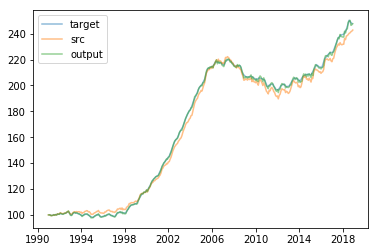

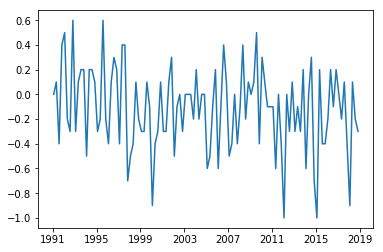

OH ENC


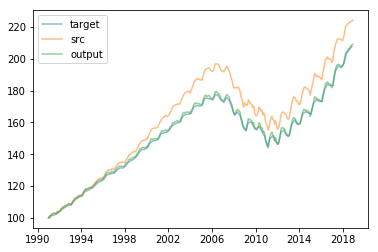

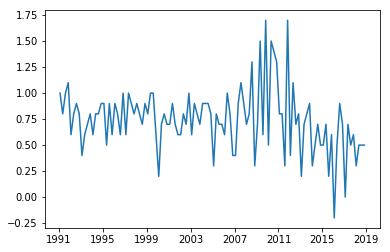

IA WNC


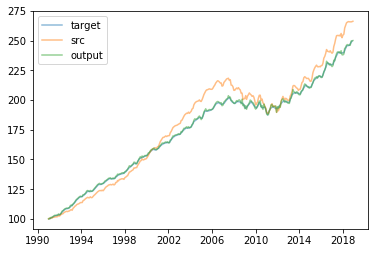

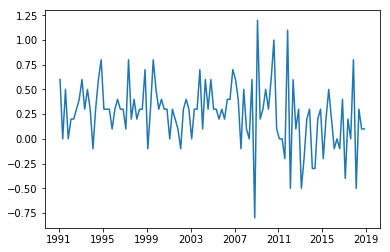

NC SA


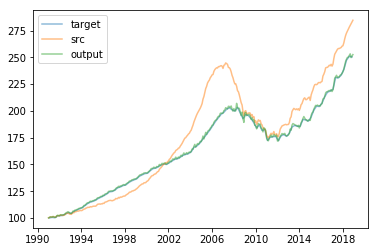

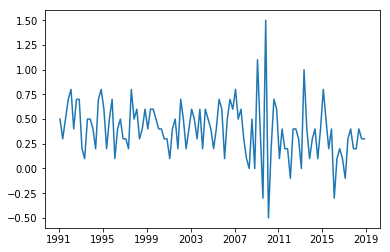

CA PAC


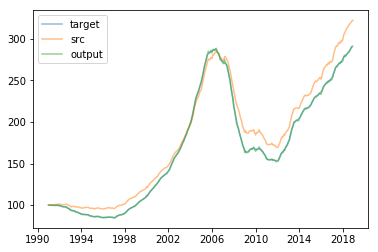

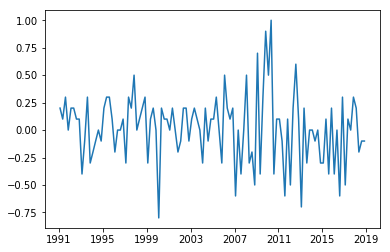

In [22]:
for i in range(len(dest.columns)):
    print dest.columns[i], src.columns[i]
    plt.plot(target.iloc[:,i],alpha=0.5)
    plt.plot(src.iloc[:,i],alpha=0.5)
    plt.plot(dest.iloc[:,i],alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(dest.iloc[:,i]/target.iloc[:,i]-1),1).dropna())
    plt.show()

In [23]:
dest.tail()

NY          OH          IA          NC          CA
Month                                                                 
2018-08-01  249.794105  206.599854  246.116603  251.789906  284.648732
2018-09-01  250.278797  206.969370  246.076049  253.326739  285.978746
2018-10-01  246.410416  208.407420  249.531372  249.835879  289.074351
2018-11-01  246.909876  208.759945  249.715160  251.250113  290.239128
2018-12-01  247.708158  209.109711  250.032017  252.620221  291.332997

In [24]:
dest.to_csv("../input/third2/HPI_po_state_monthly_arima.csv")

# zip3 monthly

In [25]:
%reset -f

In [26]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [27]:
state_po_monthly=pd.read_csv("../input/third2/HPI_po_state_monthly_arima.csv", parse_dates=['Month']).set_index('Month')
print state_po_monthly.columns
state_po_monthly.columns=['36','39','19','37','06']

Index([u'NY', u'OH', u'IA', u'NC', u'CA'], dtype='object')


In [28]:
state_po_monthly.head()

36          39          19          37          06
Month                                                                 
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000
1991-02-01  100.040000  101.000000  100.610000  100.520000  100.210000
1991-03-01   99.930000  101.350000  100.410000  100.970000  100.000000
1991-04-01   99.330001  101.730924  101.466203  100.888174   99.574089
1991-05-01   99.590001  102.350747  101.245012  100.748274   99.812685

In [27]:
state_po_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [29]:
zip3_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip3_5state_arima.csv", dtype={'zip3':np.str}).set_index("zip3").T
zip3_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in zip3_at_hpi.index])

In [30]:
zip3_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [31]:
zip3_at_hpi.tail()

zip3              028         054         057         063         068  \
2014-07-01  616.74000  609.240000  276.450000  323.060000  662.380000   
2015-07-01  641.35000  621.310000  276.480000  324.820000  677.380000   
2016-07-01  671.41000  632.320000  279.540000  328.790000  680.050000   
2017-07-01  712.74000  650.680000  284.510000  341.900000  684.020000   
2018-07-01  749.81087  670.345776  288.885673  356.132992  687.333642   

zip3               070        072         074         076         100  \
2014-07-01  731.530000  495.43000  721.650000  782.240000  285.096530   
2015-07-01  753.660000  511.77000  734.840000  799.560000  285.873000   
2016-07-01  776.650000  533.63000  750.970000  823.190000  288.323030   
2017-07-01  808.000000  574.11000  763.780000  857.350000  293.795840   
2018-07-01  834.395793  621.44127  771.893487  886.345741  297.546538   

zip3           ...            954         955        956         957  \
2014-07-01     ...       973.0000  597.720000  702.11000  681.750000   
2015-07-01     ...      1043.6700  623.000000  737.55000  706.410000   
2016-07-01     ...      1135.2900  663.070000  796.57000  755.620000   
2017-07-01     ...      1231.4500  719.240000  870.88000  822.500000   
2018-07-01     ...      1290.0542  771.692348  914.63451  859.153236   

zip3                958         959         960         961         975  \
2014-07-01   722.100000  580.100000  437.270000  639.870000  586.460000   
2015-07-01   771.560000  603.990000  461.240000  677.760000  620.520000   
2016-07-01   848.630000  653.590000  478.220000  727.100000  672.280000   
2017-07-01   946.710000  707.740000  507.660000  780.780000  733.410000   
2018-07-01  1009.301403  736.388578  539.445551  816.696917  762.661386   

zip3               976  
2014-07-01  325.240000  
2015-07-01  341.530000  
2016-07-01  354.810000  
2017-07-01  381.040000  
2018-07-01  404.220987  

[5 rows x 240 columns]

In [32]:
def read_zip3_to_state():
    zip_block=dd.read_parquet("../input/info/censusblockinfo_with_zip.parq").compute()
    zip_block['zip3']=zip_block['zip'].map(lambda u: u[:3])
    a=zip_block[['zip3','state']].drop_duplicates()
    assert a.groupby("zip3").count().state.value_counts().shape[0]==1
    return dict(a.values)
zip3_to_state=read_zip3_to_state()
len(zip3_to_state)

242

In [33]:
src=state_po_monthly.sort_index()
target=zip3_at_hpi.sort_index()

In [34]:
from dateutil.relativedelta import relativedelta

In [35]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [36]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [37]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [38]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [39]:
len(target.columns)

240

In [40]:
dest=[]
for col in target.columns[:]:
    target_s=target[col]
    src_s=src[zip3_to_state[col]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

194 915


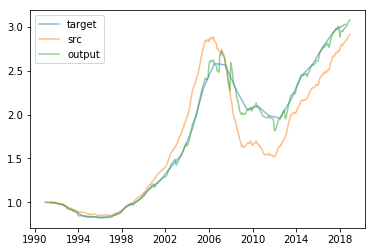

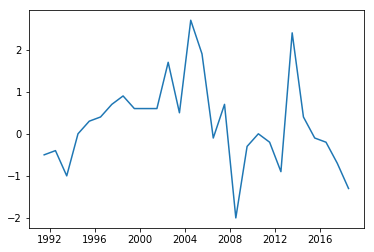

131 473


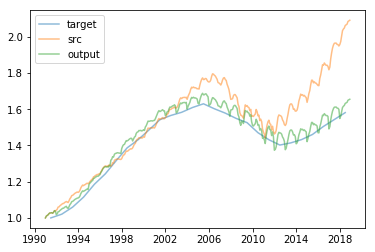

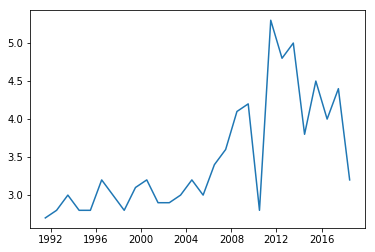

39 132


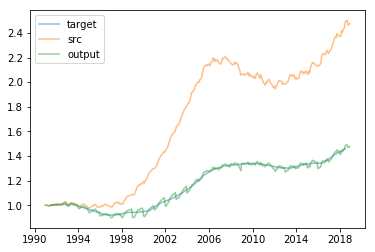

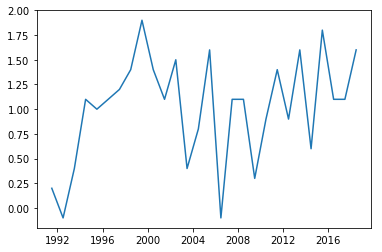

83 281


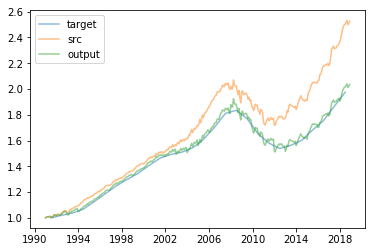

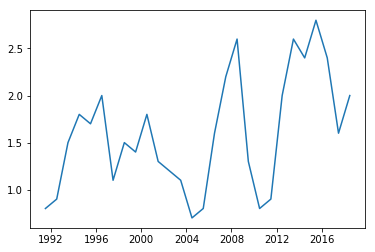

115 443


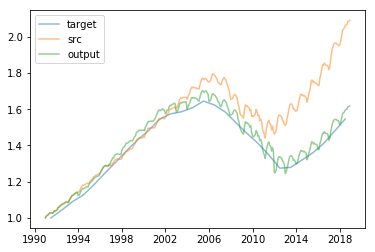

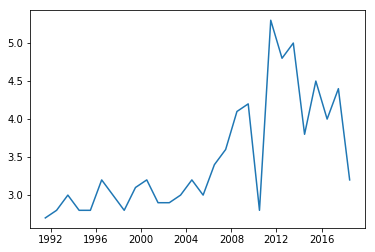

147 514


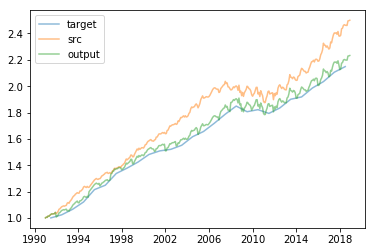

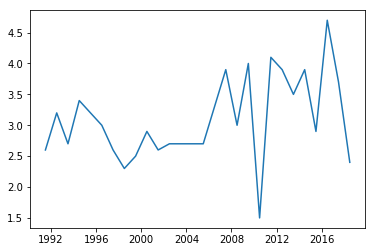

71 261


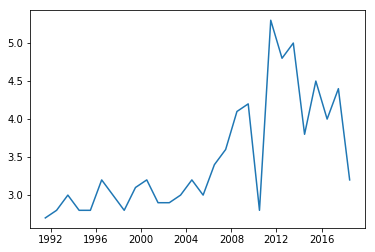

155 525


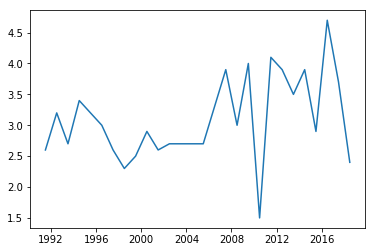

205 926


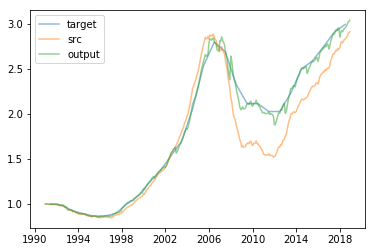

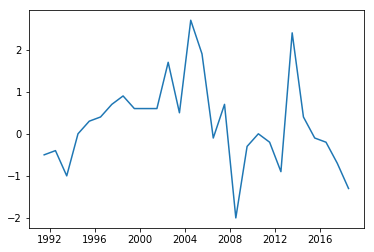

193 914


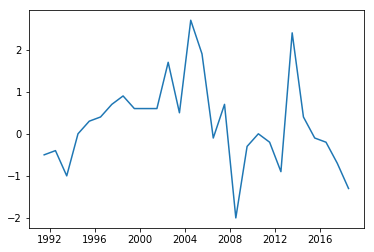

In [41]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,zip3_to_state[dest.columns[i]]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [42]:
dest.tail()

zip3               028         054         057         063         068  \
Month                                                                    
2018-08-01  211.644113  228.309927  160.972865  163.342429  196.493242   
2018-09-01  212.054780  228.752932  161.285212  163.659373  196.874511   
2018-10-01  208.777201  225.217261  158.792341  161.129807  193.831562   
2018-11-01  209.200380  225.673763  159.114204  161.456408  194.224448   
2018-12-01  209.876744  226.403387  159.628635  161.978411  194.852393   

zip3               070         072         074         076         100  \
Month                                                                    
2018-08-01  235.356562  193.143978  212.888930  233.963147  320.887251   
2018-09-01  235.813240  193.518748  213.302012  234.417121  321.509890   
2018-10-01  232.168443  190.527667  210.005155  230.793903  316.540541   
2018-11-01  232.639035  190.913856  210.430824  231.261709  317.182151   
2018-12-01  233.391179  191.531098  211.111166  232.009400  318.207630   

zip3           ...             954         955         956         957  \
Month          ...                                                       
2018-08-01     ...      271.530139  266.166640  217.705943  210.007833   
2018-09-01     ...      272.798857  267.410297  218.723169  210.989089   
2018-10-01     ...      275.751795  270.304906  221.090759  213.272961   
2018-11-01     ...      276.862891  271.394054  221.981608  214.132309   
2018-12-01     ...      277.906347  272.416899  222.818224  214.939343   

zip3               958         959         960         961         975  \
Month                                                                    
2018-08-01  219.960935  215.282483  209.790850  284.318950  282.965596   
2018-09-01  220.988696  216.288385  210.771092  285.647423  284.287745   
2018-10-01  223.380810  218.629620  213.052605  288.739441  287.365046   
2018-11-01  224.280886  219.510552  213.911065  289.902869  288.522936   
2018-12-01  225.126168  220.337855  214.717265  290.995471  289.610337   

zip3               976  
Month                   
2018-08-01  248.774589  
2018-09-01  249.936982  
2018-10-01  252.642449  
2018-11-01  253.660430  
2018-12-01  254.616439  

[5 rows x 240 columns]

In [43]:
dest.to_csv("../input/third2/HPI_at_zip3_monthly_arima.csv")

# zip5 monthly

In [44]:
%reset -f

In [45]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [46]:
zip3_at_monthly=pd.read_csv("../input/third2/HPI_at_zip3_monthly_arima.csv", parse_dates=['Month']).set_index('Month')


In [47]:
zip3_at_monthly.head()

028         054         057         063         068  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.040000  100.040000  100.040000  100.040000  100.040000   
1991-03-01   99.930000   99.930000   99.930000   99.930000   99.930000   
1991-04-01   99.330001   99.330001   99.330001   99.330001   99.330001   
1991-05-01   99.590001   99.590001   99.590001   99.590001   99.590001   

                   070         072         074         076         100  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.040000  100.040000  100.040000  100.040000  100.040000   
1991-03-01   99.930000   99.930000   99.930000   99.930000   99.930000   
1991-04-01   99.330001   99.330001   99.330001   99.330001   99.330001   
1991-05-01   99.590001   99.590001   99.590001   99.590001   99.590001   

               ...             954         955         956         957  \
Month          ...                                                       
1991-01-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-02-01     ...      100.210000  100.210000  100.210000  100.210000   
1991-03-01     ...      100.000000  100.000000  100.000000  100.000000   
1991-04-01     ...       99.574089   99.574089   99.574089   99.574089   
1991-05-01     ...       99.812685   99.812685   99.812685   99.812685   

                   958         959         960         961         975  \
Month                                                                    
1991-01-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-02-01  100.210000  100.210000  100.210000  100.210000  100.210000   
1991-03-01  100.000000  100.000000  100.000000  100.000000  100.000000   
1991-04-01   99.574089   99.574089   99.574089   99.574089   99.574089   
1991-05-01   99.812685   99.812685   99.812685   99.812685   99.812685   

                   976  
Month                   
1991-01-01  100.000000  
1991-02-01  100.210000  
1991-03-01  100.000000  
1991-04-01   99.574089  
1991-05-01   99.812685  

[5 rows x 240 columns]

In [48]:
assert zip3_at_monthly.isnull().sum().sum()==0

In [49]:
zip3_at_monthly.index.max()

Timestamp('2018-12-01 00:00:00')

In [50]:
zip5_at_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip5_5state_arima.csv", dtype={'zip5':np.str}).set_index("zip5").T
zip5_at_hpi.index=pd.to_datetime(['{}-07-01'.format(u) for u in zip5_at_hpi.index])

In [51]:
zip5_at_hpi.index.max()

Timestamp('2018-07-01 00:00:00')

In [52]:
zip5_at_hpi.head()

zip5         02891      05458      05734      05743      05764     05770  \
1991-07-01  148.84   99.82007  88.694600  102.02251  99.440640  79.47828   
1992-07-01  148.26  100.00000  86.936300  100.00000  97.469315  77.90269   
1993-07-01  145.44  101.64000  86.117710   94.54000  96.551540  77.16915   
1994-07-01  142.08   90.05000  84.272224   85.54000  94.482460  75.51543   
1995-07-01  144.60   98.35000  83.671590   84.51000  93.809060  74.97721   

zip5         06853   07002   07008      07020    ...       96130   96137  \
1991-07-01  114.98  299.99  182.58  86.381220    ...      153.59  118.99   
1992-07-01  113.66  310.86  189.61  86.870760    ...      160.61  124.31   
1993-07-01  117.12  297.35  180.61  87.763880    ...      164.33  132.70   
1994-07-01  114.89  314.16  177.27  87.938200    ...      168.11  136.97   
1995-07-01  119.35  279.09  178.71  87.551346    ...      185.98  128.81   

zip5            96140      96142   96145   96146   96150   96161      97523  \
1991-07-01  56.733833  52.674000  100.00  100.00  291.37  163.11   95.17639   
1992-07-01  58.732876  54.529995  110.26  107.94  302.28  169.15  100.00000   
1993-07-01  59.865803  55.581850  103.75  108.97  306.51  173.29  111.92000   
1994-07-01  60.843422  56.489510  105.70  112.76  313.99  173.23  113.65000   
1995-07-01  62.509956  58.036790  118.36  120.61  320.78  176.59  127.27000   

zip5            97623  
1991-07-01  55.879906  
1992-07-01  59.832200  
1993-07-01  61.908890  
1994-07-01  69.303840  
1995-07-01  73.471085  

[5 rows x 4088 columns]

In [53]:
src=zip3_at_monthly.sort_index()
target=zip5_at_hpi.sort_index()

In [54]:
from dateutil.relativedelta import relativedelta

In [55]:
def make_year(yr):
    return pd.to_datetime(['{}-{}-01'.format(yr,m) for m in range(1,13)])

In [56]:
def make_src_ratio(src,yr):
    quarter_dts1=make_year(yr)
    quarter_dts2=make_year(yr-1)
    return src.loc[quarter_dts1].values/src.loc[quarter_dts2].values


In [57]:
make_year(target.index[0].year)

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01', '1991-07-01', '1991-08-01',
               '1991-09-01', '1991-10-01', '1991-11-01', '1991-12-01'],
              dtype='datetime64[ns]', freq=None)

In [58]:
def make_series(src_s, target_s):
    lst=[]
    for i, dt in enumerate(target_s.index):
        dt=dt.year
        quarter_dts=make_year(dt)
        svs=src_s.loc[quarter_dts]
        if i==0:
            lst.append(svs.values)
        else:
            tv2=target_s.iloc[i]
            tv1=target_s.iloc[i-1]
            last_quarter=lst[-1]
            r=make_src_ratio(src_s,dt)
            k= tv2/tv1/np.mean(r)
            #k=np.exp(np.log(tv2/tv1) - np.mean(np.log(r)))
            
            #print last_quarter, r,k,tv2,tv1,k
            lst.append(k*r*last_quarter)
    lst=np.concatenate(lst,axis=0)
    return lst
            


In [59]:
len(target.columns)

4088

In [60]:
%%time 
dest=[]
for i, col in enumerate(target.columns[:]):
    if i%1000==0: print i,
    target_s=target[col]
    src_s=src[col[:3]]
    dest_s= make_series(src_s,target_s)
    dest.append(dest_s)
dest=pd.DataFrame( np.array(dest).T,columns=target.columns[:len(dest)],index=src.index)

0 1000 2000 3000 4000CPU times: user 2min 2s, sys: 884 ms, total: 2min 3s
Wall time: 2min 2s



1200 28071


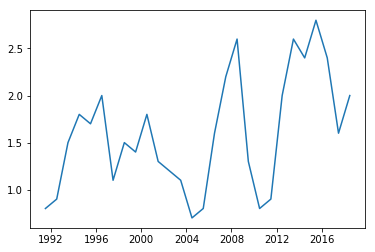

3295 92648


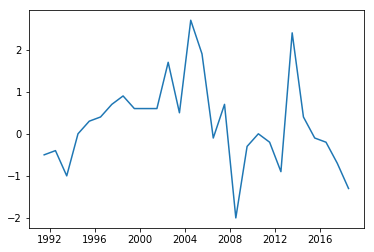

3537 93933


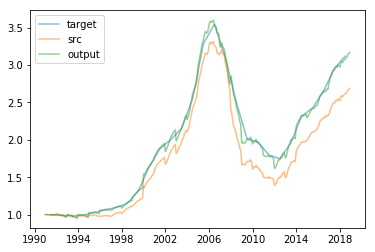

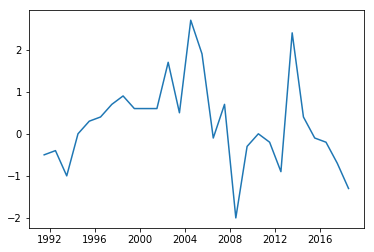

2195 45304


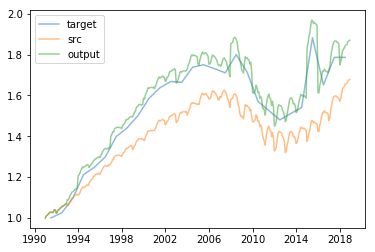

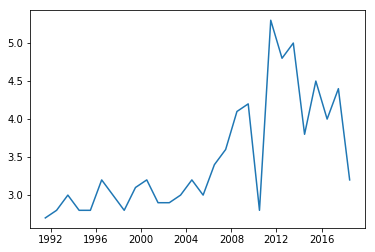

1312 28387


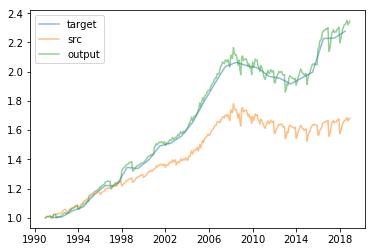

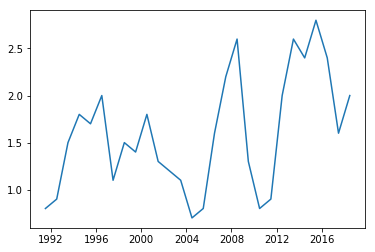

1639 43337


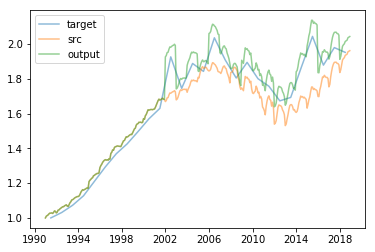

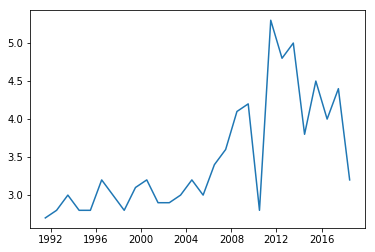

4069 96094


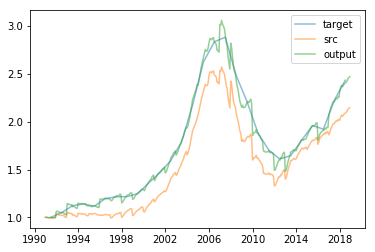

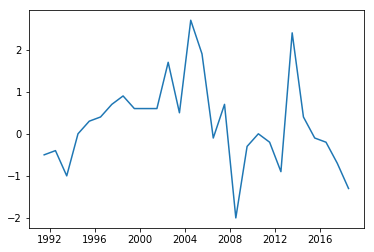

3800 95306


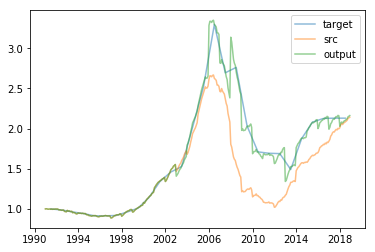

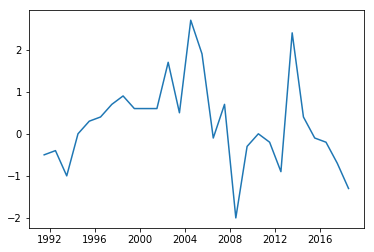

527 12553


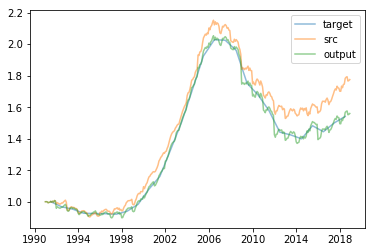

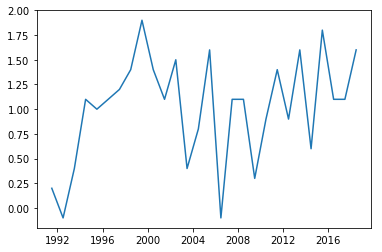

3165 92139


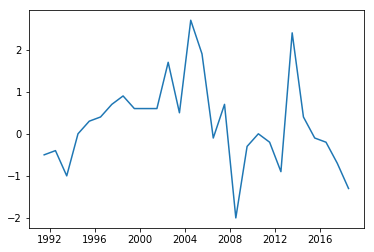

In [61]:
f=lambda u:u/u[0]
for i in np.random.choice(range(len(dest.columns)),10):
    print i, dest.columns[i] 
    plt.plot(f(target.iloc[:,i]),alpha=0.5)
    plt.plot(f(src.loc[:,dest.columns[i][:3]]),alpha=0.5)
    plt.plot(f(dest.iloc[:,i]),alpha=0.5)
    plt.legend(['target','src','output'])
    plt.show()
    plt.plot( np.round(100*(f(dest.iloc[:,i])/f(target.iloc[:,i])-1),1).dropna())
    plt.show()

In [64]:
dest.tail(7)

zip5             02891       05458       05734       05743       05764  \
Month                                                                    
2018-06-01  224.136253  232.552455  206.533732  142.250853  130.247655   
2018-07-01  228.870891  237.464877  210.896536  145.255749  132.998997   
2018-08-01  229.735280  238.361723  211.693041  145.804345  133.501302   
2018-09-01  230.181051  238.824232  212.103803  146.087259  133.760343   
2018-10-01  226.623307  235.132897  208.825466  143.829292  131.692905   
2018-11-01  227.082659  235.609498  209.248743  144.120826  131.959839   
2018-12-01  227.816838  236.371245  209.925263  144.586782  132.386477   

zip5             05770       06853       07002       07008       07020  \
Month                                                                    
2018-06-01  181.398783  267.194562  220.479648  208.025331  369.221017   
2018-07-01  185.230638  272.838761  225.137044  212.419643  377.020416   
2018-08-01  185.930209  273.869206  225.987332  213.221900  378.444330   
2018-09-01  186.290982  274.400613  226.425830  213.635629  379.178650   
2018-10-01  183.411615  270.159398  222.926128  210.333616  373.317957   
2018-11-01  183.783380  270.706996  223.377987  210.759950  374.074651   
2018-12-01  184.377569  271.582217  224.100188  211.441356  375.284069   

zip5           ...           96130       96137       96140       96142  \
Month          ...                                                       
2018-06-01     ...      186.482987  244.062420  292.684325  289.178115   
2018-07-01     ...      186.944405  244.666308  293.408520  289.893634   
2018-08-01     ...      187.891889  245.906341  294.895591  291.362891   
2018-09-01     ...      188.769809  247.055332  296.273483  292.724277   
2018-10-01     ...      190.813166  249.729607  299.480525  295.892899   
2018-11-01     ...      191.582016  250.735851  300.687232  297.085151   
2018-12-01     ...      192.304061  251.680838  301.820478  298.204821   

zip5             96145       96146       96150       96161       97523  \
Month                                                                    
2018-06-01  339.125567  336.140165  316.802515  347.379157  365.257479   
2018-07-01  339.964672  336.971883  317.586386  348.238684  366.161243   
2018-08-01  341.687702  338.679746  319.195997  350.003650  368.017044   
2018-09-01  343.284229  340.262218  320.687432  351.639033  369.736595   
2018-10-01  347.000143  343.945420  324.158745  355.445384  373.738845   
2018-11-01  348.398323  345.331291  325.464889  356.877592  375.244763   
2018-12-01  349.711385  346.632794  326.691518  358.222612  376.659006   

zip5             97623  
Month                   
2018-06-01  209.556802  
2018-07-01  210.075312  
2018-08-01  211.140029  
2018-09-01  212.126575  
2018-10-01  214.422760  
2018-11-01  215.286741  
2018-12-01  216.098126  

[7 rows x 4088 columns]

In [63]:
dest.to_csv("../input/third2/HPI_at_zip5_monthly_arima.csv")